In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Goal of this notebook is to create the subset of substructures that we'll use for benchmarking and learning. The count distribution of many of these substructures (e.g. domains) is very long-tailed, so there are many domains with few observations. This is particularly exacerbated by subsetting to just SwissProt. If we expand to more proteins (e.g. all of UniProt) in the future, then we'll want to revisit these cutoffs.

# Load stats

Stats below were pre-computed using `scripts/calc_stats.py`

In [3]:
interpro_path = "/weka/scratch/weka/kellislab/rcalef/data/interpro/103.0/"

In [4]:
stats_dir = os.path.join(
    interpro_path,
    "swissprot",
    "summary_stats",
)

def load_stats(interpro_type: str) -> pd.DataFrame:
    stats_path = os.path.join(stats_dir, f"{interpro_type}_summaries.tsv")
    return pd.read_table(stats_path)

In [5]:
want_types = [
    "Family",
    "Domain",
    "Homologous_superfamily",
    "Conserved_site",
    #"Repeat",
    "Active_site",
    "Binding_site",
    "PTM",
]

combined_stats = []
for type in want_types:
    combined_stats.append(
        load_stats(type)
        .assign(
            element_type=type,
        )
    )
combined_stats = pd.concat(combined_stats)

print(combined_stats.shape)
combined_stats.head()

(46675, 12)


,element_id,element_name,count,max_occurences,min_len,max_len,avg_len,min_num_segs,max_num_segs,avg_num_segs,avg_coverage,element_type
0,IPR000003,Retinoid X receptor/HNF4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family
1,IPR000006,"Metallothionein, vertebrate",253,2,39.0,67.0,59.715415,1.0,1.0,1.0,0.981059,Family
2,IPR000009,Protein phosphatase 2A regulatory subunit PR55,40,1,411.0,525.0,453.150000,1.0,1.0,1.0,0.979235,Family
3,IPR000011,Ubiquitin/SUMO-activating enzyme E1-like,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family
4,IPR000012,Retroviral VpR/VpX protein,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Family


# Counts per element type

In [6]:
element_counts = combined_stats.element_type.value_counts()
element_counts

element_type
Family                    26322
Domain                    15868
Homologous_superfamily     3511
Conserved_site              748
Active_site                 133
Binding_site                 76
PTM                          17
Name: count, dtype: int64

Text(0.5, 1.0, 'All InterPro entries')

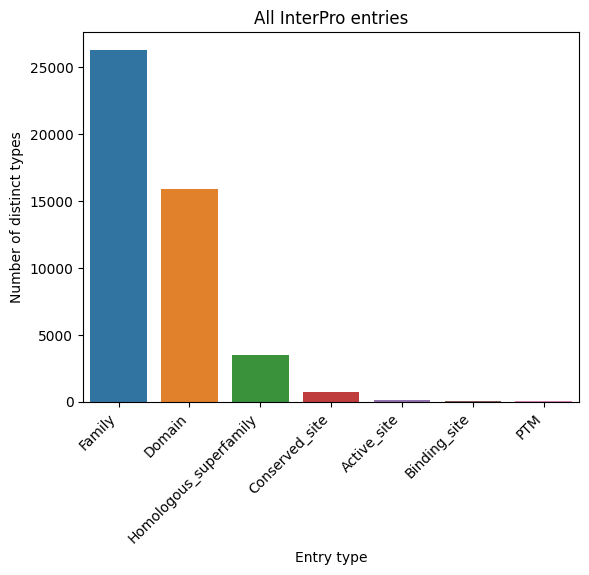

In [7]:
sns.barplot(
    x="element_type",
    hue="element_type",
    y="count",
    data=element_counts.reset_index(),
    hue_order=want_types,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of distinct types")
plt.xlabel("Entry type")
plt.title("All InterPro entries")

In [8]:
# Remove annotations with zero observations in our SwissProt subset.
combined_stats_nonzero = (
    combined_stats
    .loc[lambda x: x["count"] != 0]
)
element_counts = combined_stats_nonzero.element_type.value_counts()
element_counts

element_type
Family                    17376
Domain                     9133
Homologous_superfamily     2978
Conserved_site              739
Active_site                 132
Binding_site                 76
PTM                          17
Name: count, dtype: int64

Text(0.5, 1.0, 'InterPro entries w/ non-zero count in SwissProt')

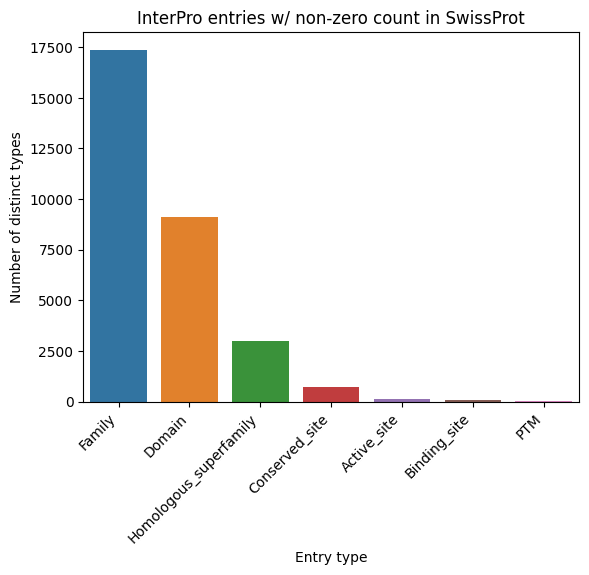

In [9]:
sns.barplot(
    x="element_type",
    hue="element_type",
    y="count",
    data=element_counts.reset_index(),
    hue_order=want_types,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of distinct types")
plt.xlabel("Entry type")
plt.title("InterPro entries w/ non-zero count in SwissProt")

Text(0.5, 0, 'Entry type')

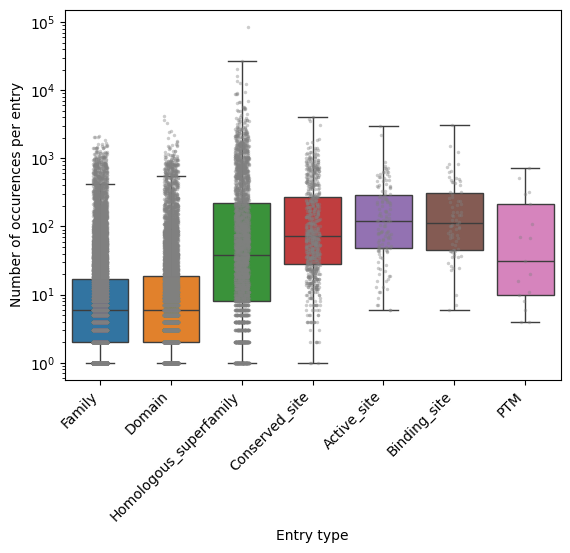

In [10]:
sns.boxplot(
    x="element_type",
    y="count",
    hue="element_type",
    data=combined_stats_nonzero,
    hue_order=want_types,
    log_scale=True,
    fliersize=0,
    # Reduce alpha on all boxplot elements.
)

sns.stripplot(
    x="element_type",
    y="count",
    data=combined_stats_nonzero,
    log_scale=True,
    marker=".",
    alpha=0.4,
    color="grey",
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of occurences per entry")
plt.xlabel("Entry type")
#plt.title("InterPro entries w/ non-zero count in SwissProt")

Text(0.5, 0, 'Entry type')

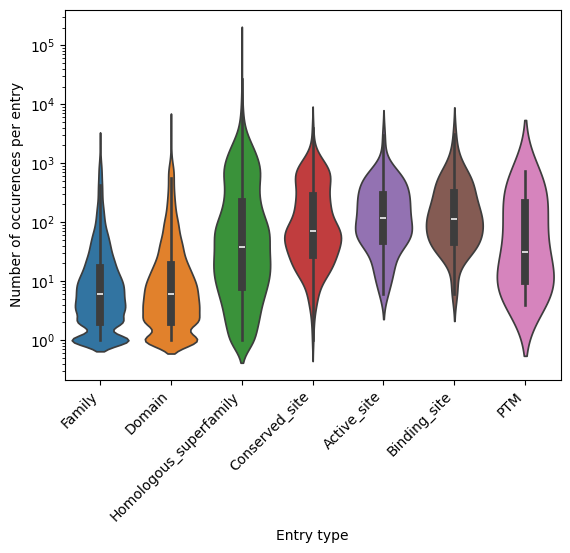

In [11]:
sns.violinplot(
    x="element_type",
    y="count",
    hue="element_type",
    data=combined_stats_nonzero,
    hue_order=want_types,
    log_scale=True,
    # Reduce alpha on all boxplot elements.
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of occurences per entry")
plt.xlabel("Entry type")
#plt.title("InterPro entries w/ non-zero count in SwissProt")

# Number of elements and occurences by count threshold

In [12]:
(
    combined_stats_nonzero
    .groupby("element_type")["count"]
    .describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])
)

,count,mean,std,min,25%,50%,75%,80%,90%,95%,max
element_type,,,,,,,,,,,
Active_site,132.0,235.295455,361.510376,6.0,48.75,119.0,286.00,384.4,566.8,675.70,3005.0
Binding_site,76.0,264.947368,433.547411,6.0,45.75,112.5,307.75,430.0,579.0,819.75,3123.0
Conserved_site,739.0,237.056834,400.923064,1.0,28.00,72.0,273.00,406.4,702.2,922.10,4037.0
Domain,9133.0,42.653892,151.441164,1.0,2.00,6.0,19.00,28.0,77.0,190.00,4138.0
Family,17376.0,33.937845,116.887370,1.0,2.00,6.0,17.00,24.0,58.0,133.00,2163.0
Homologous_superfamily,2978.0,365.923774,1900.087972,1.0,8.00,38.0,219.00,363.2,934.3,1568.90,85501.0
PTM,17.0,143.588235,211.338904,4.0,10.00,31.0,212.00,284.8,399.6,554.80,734.0


As a somewhat arbitrary choice, we'll use the 90th percentile of counts from domains as the cutoff. This will keep the top 10% of domains in terms of number of observations. Since the other element classes have fewer annotation types, this is most strict for domains (and families, which we may or may not use at all).

Given that we'll do an 80-10-10 split of the dataset, this is roughly a minimum of 60 observations in the train set, which seems reasonable for now.

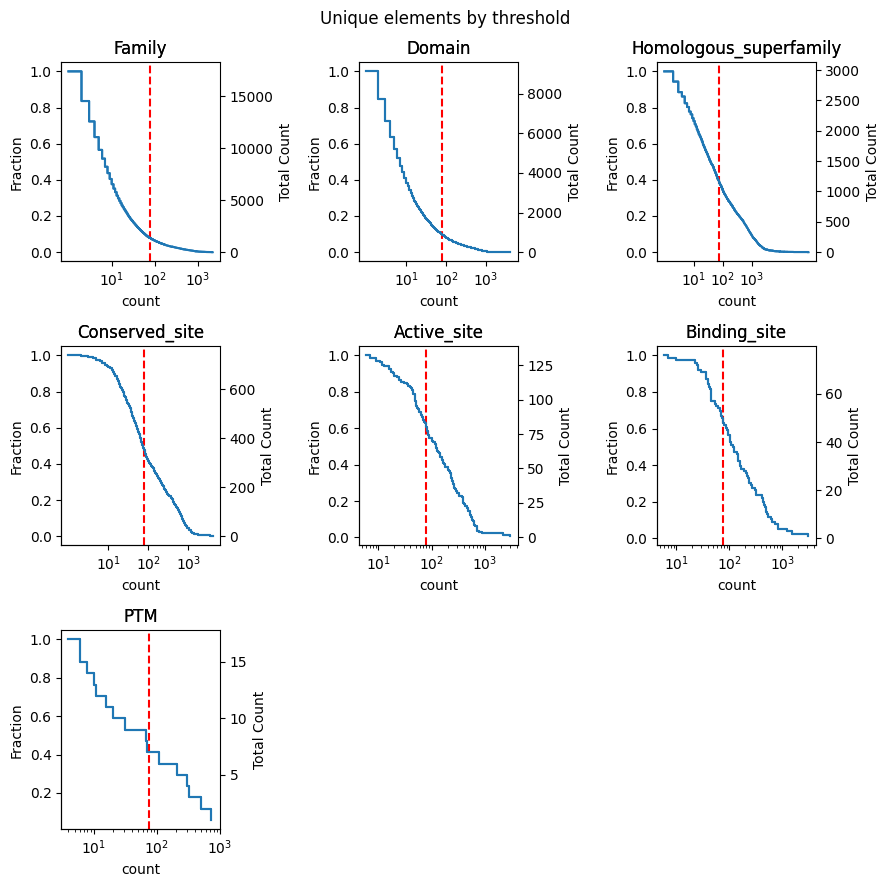

In [13]:
# Create a FacetGrid
g = sns.FacetGrid(combined_stats_nonzero, col="element_type", col_wrap=3, sharex=False, sharey=False)

# Define the plotting function
def plot_facet(data, **kwargs):
    elem_type = data['element_type'].iloc[0]

    # Calculate the inverse CDF
    counts = data["count"].value_counts().sort_index()
    cdf = counts.cumsum()
    inverse_cdf = cdf.max() - cdf + counts

    # Plot the inverse CDF for probability
    sns.lineplot(
        x=inverse_cdf.index,
        y=inverse_cdf / inverse_cdf.max(),
        drawstyle='steps-post',
        **kwargs
    )
    ax = plt.gca()
    ax.axvline(77, color="red", linestyle="--")
    ax.set_ylabel("Fraction")

    # Plot the inverse CDF for count
    ax2 = ax.twinx()
    sns.lineplot(
        x=inverse_cdf.index,
        y=inverse_cdf,
        drawstyle='steps-post',
        ax=ax2,
        **kwargs
    )
    ax2.set_ylabel("Total Count")
    plt.xscale("log")
    plt.xlabel("Num occurrences")
    plt.title(elem_type)
    plt.xticks([10**1, 10**2, 10**3], labels=[r"$10^1$", r"$10^2$", r"$10^3$"])

# Map the plotting function to each facet
g.map_dataframe(plot_facet)

# Adjust titles to show only the element type
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

plt.suptitle("Unique elements by threshold")

# Adjust layout
plt.tight_layout()
plt.show()

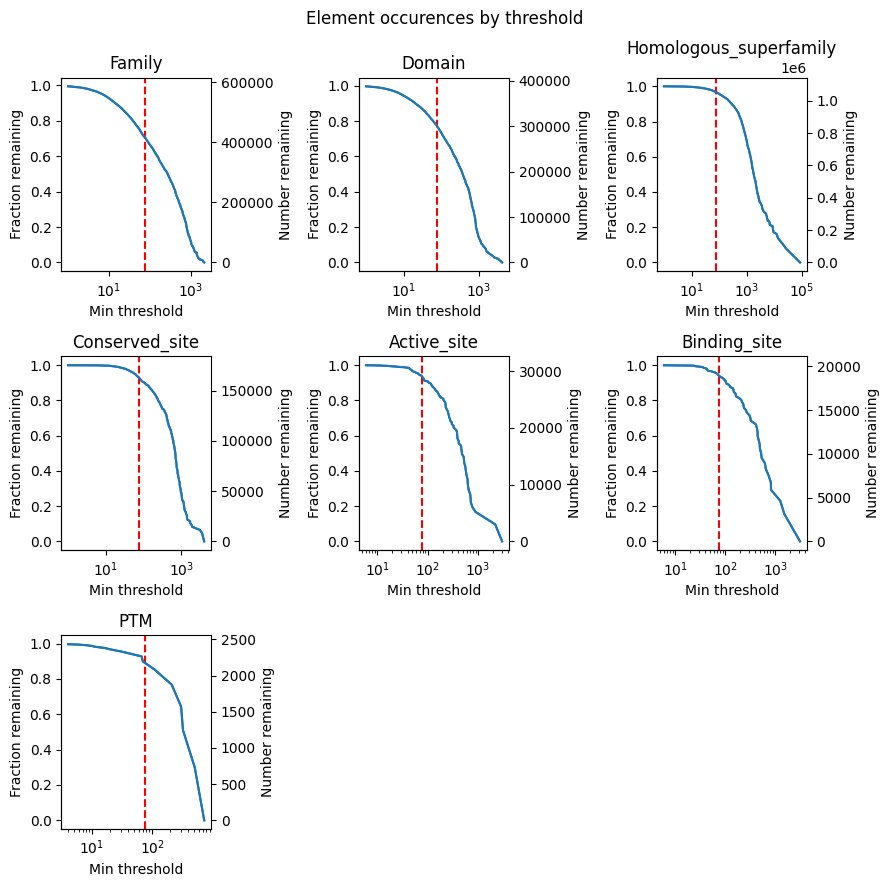

In [14]:
# Create a FacetGrid
g = sns.FacetGrid(combined_stats_nonzero, col="element_type", col_wrap=3, sharex=False, sharey=False)

# Define the plotting function
def plot_facet(data, **kwargs):
    elem_type = data['element_type'].iloc[0]
    plot_data = (
        combined_stats_nonzero
        .query("element_type == @elem_type")
        .sort_values("count", ascending=True)
        .assign(
            remaining=lambda x: x["count"].sum() - x["count"].cumsum(),
            frac_remaining=lambda x: x.remaining / x["count"].sum(),
        )
        .drop_duplicates("count", keep="last")
    )
    sns.lineplot(
        x="count",
        y="frac_remaining",
        data=plot_data,
    )
    plt.xlabel("Min threshold")
    ax = plt.gca()
    ax.axvline(77, color="red", linestyle="--")

    ax.set_ylabel("Fraction remaining")

    ax2 = ax.twinx()
    sns.lineplot(
        x="count",
        y="remaining",
        data=plot_data,
        ax=ax2,
    )
    ax2.set_ylabel("Number remaining")

    plt.xscale("log")

# Map the plotting function to each facet
g.map_dataframe(plot_facet)

# Adjust titles to show only the element type
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title)

plt.suptitle("Element occurences by threshold")

# Adjust layout
plt.tight_layout()
plt.show()

# Output label subset

In [15]:
selected_labels = combined_stats_nonzero.query("count >= 77")

In [16]:
selected_labels.element_type.value_counts()

element_type
Family                    1353
Homologous_superfamily    1133
Domain                     917
Conserved_site             356
Active_site                 82
Binding_site                48
PTM                          6
Name: count, dtype: int64

In [17]:
outdir = "/weka/scratch/weka/kellislab/rcalef/data/interpro/103.0/label_sets/selected_subset"
for element_type, elems in selected_labels.groupby("element_type"):
    elem_labels = selected_labels.query("element_type == @element_type")
    assert not elems.element_name.duplicated().any()
    label_set = elem_labels.sort_values("element_id")
    label_df = pd.DataFrame(
        {
            "label": np.arange(len(label_set)),
            "element_name": label_set.element_name,
            "interpro_id": label_set.element_id,
        }
    )
    with open(
        os.path.expanduser(
            os.path.join(outdir, f"{element_type}.labels.tsv")
        ),
        "w",
    ) as fh:
        label_df.to_csv(fh, sep="\t", index=False)